### 목적
- Xception 구현하기

#### 참고사이트
- Keras Classification: https://keras.io/examples/vision/image_classification_from_scratch/
- Keras Xception: https://github.com/fchollet/deep-learning-models/blob/master/xception.py
- kears cat vs dog: https://junstar92.tistory.com/119

In [101]:
# daataset load간 필요한 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
import PIL.Image
import os 

# data 전처리
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img

# Xception model 구성할 모듈
import warnings
import tensorflow as tf
from __future__ import print_function
from __future__ import absolute_import
from keras.preprocessing import image


from keras.models import Model
from keras import layers
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions

#### Dataset load

[1] 수동 작업 
- Imagenet data 가져오기: https://www.kaggle.com/competitions/dogs-vs-cats/data

[2]

In [3]:
# zip file dictionary 설정
dataset_dir = "./dogs-vs-cats"                     # dataset zil file이 있는 dictionary 
train_dir = os.path.join(dataset_dir, 'train.zip') # train dictionary 생성
test_dir = os.path.join(dataset_dir, 'test.zip')   # test dictionary 생성
 
# 압축 해제
import zipfile

with zipfile.ZipFile(train_dir, 'r') as f:         # train file 압축해제
    f.extractall()
with zipfile.ZipFile(test_dir, 'r') as z:          # test file 압축해제
    z.extractall()

In [4]:
# train 데이터 불러오기
IMAGE_FOLDER_PATH = "./train"
FILE_PATH = [os.path.join(IMAGE_FOLDER_PATH,i) for i in os.listdir(IMAGE_FOLDER_PATH)]

# image name 불러오기
labels=[i for i in os.listdir(IMAGE_FOLDER_PATH)]

# Targets 정의 
targets=[i.split('.')[0] for i in labels]
y=targets

# Dataframe 만들기
data = pd.DataFrame({'PATH':FILE_PATH,'targets':targets}); data.head()

,PATH,targets
0,./train\cat.0.jpg,cat
1,./train\cat.1.jpg,cat
2,./train\cat.10.jpg,cat
3,./train\cat.100.jpg,cat
4,./train\cat.1000.jpg,cat


#### Train / Validation dataset 분할

In [111]:
# dataset에서 train / validation set 분할
train_df, val_df = train_test_split(data, test_size=0.20, random_state=0)

# 필요한 변수 정의
img_size = (299,299)
batch_size = 1024

# image dataset 객채 새성
dataimg =ImageDataGenerator(rescale=1./255)

# train dataset 생성 (image size = 299, 299 / batchsize = 32)
train=dataimg.flow_from_dataframe(dataframe=train_df, x_col="PATH", y_col="targets",
                                     target_size= img_size, batch_size = batch_size, class_mode="binary")

# validation datset 생성
val=dataimg.flow_from_dataframe(dataframe=val_df, x_col="PATH", y_col="targets",
                                     target_size= img_size, batch_size = batch_size, class_mode="binary")

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


#### visualization

<ipython-input-112-5178b6cf15f9>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


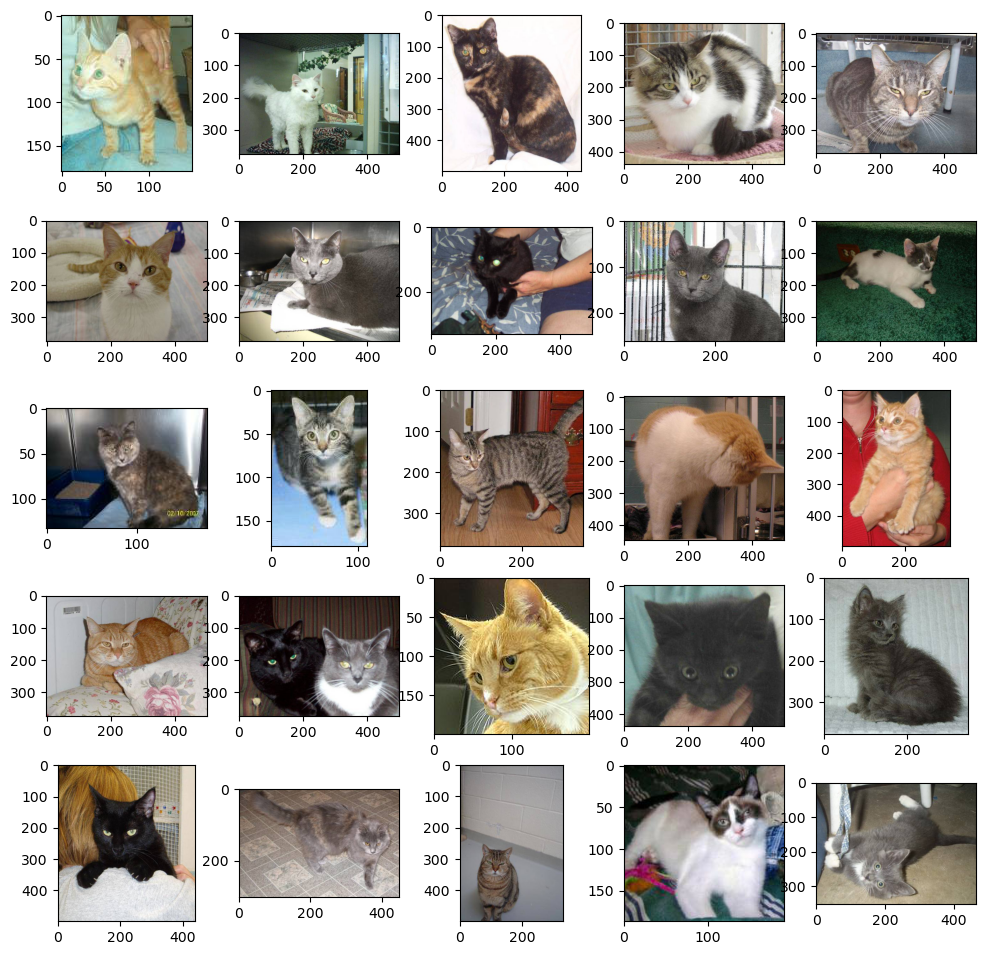

In [112]:
def gallery(nrow,ncol,name):    # This function creates a grid of images from  dataset.
    
    img_df = train_df[train_df['targets'] == name]   # little data sorting
    path_df = img_df['PATH']
    
    # Gallery using Matplotlib 
    fig, ax = plt.subplots(nrow,ncol,figsize = (12,12), dpi = 100)
    axes = ax.ravel()
    
    for idx,ax  in enumerate(axes):
        ax.imshow(load_img(path_df.iloc[idx]))
    return fig.show()

#### cat data 시각화

gallery(5,5,name='cat')

#### model 

[1] 설명
- SeparableConv2D: https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728


In [ ]:
def make_model(input_shape = None, num_classes = 1000, include_top = True, pooling=None):
    inputs = keras.Input(shape=input_shape)
    
    # 1. Entry flow 특징
    ## 공통점 [1]: 논문에서 언급된 것처럼 모든 convolution(잔차 포함) 뒤에는 batchnormalization 진행  /  Actvivatino function : Relu
    ## 차이점: [1] padding 입력: 첫번째 block의 경우 valid / 나머지 same) 
    ##         [2] resdiual block 여부: 첫번째 block의 경우 없음
    ##         [3] max pooling 여부
 

    # 1-1 block: 3 by 3 filter, channel: 32. stride: 2 => batch normzliation => activation function 
    # 크기: 149 * 149 * 32
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(inputs)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)

    
    # 1-2 block: 3 by 3 filter, channel: 64 => batch normzliation => activation function
    # 크기: 147 * 147 * 64
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    
    # 1-3 잔차 : 1 by 1 filter, channle: 128, stride 2 => batch normalization
    # 크기: 74 * 74 * 128
    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    
    # 1-3 block => 주의할점(separable convolution 등장하는 block 중에서는 처음과 맨 마지막 block만 처음에 convolution 등장)
    ## [1] 3 by 3ffilter, channel, channeel, 128 (separable convolution) => batchnormalization => activation function 
    ## 크기: 147 * 147 * 128
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    
    ## [2] 3 by 3ffilter, channel, channeel, 128 (separable convolution) => batchnormalization 
    ## 크기: 147 * 147 * 128
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    ## [3] maxpooling 진행(3 by 3 filter , stride: 2) 
    ## 크기: 74 * 74 * 128
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    
    ## 1-3 block + 잔차 연결
    x = layers.add([x, residual])

    
    # 1-4 잔차: 1 by 1 filter, channle: 256, stride 2 => batch normalization
    # 크기: 37 * 37 * 256
    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    
    # 1-4 block
    ## [1] Activation function => 3 * 3 filter, channel: 256 => batch normazliation
    ## 크기: 74 * 74 * 256
    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    
    ## [2] Activation function => 3 * 3 filter, channel: 255 => batch normazliation
    ## 크기: 74 * 74 * 256
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    ## [3] maxpooling 진행(3 by 3 filter , stride: 2) 
    ## 크기: 37 * 37 * 128
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    
    ## 1-4 block + 잔차 연결 : 37 * 37 * 128
    x = layers.add([x, residual])

    
    # 1-5 잔차: 1 by 1 filter, channle: 728, stride 2 => batch normalization
    # 크기: 37 * 37 * 256
    residual = Conv2D(728, (1, 1), strides=(2, 2), adding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    # 1-5 block
    ## [1] Activation function => 3 * 3 filter, channel: 728 => batch normazliation
    ## 크기: 74 * 74 * 728  
    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    
    ## [2] Activation function => 3 * 3 filter, channel: 728 => batch normazliation
    ## 크기: 74 * 74 * 728
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    ## [3] maxpooling 진행(3 by 3 filter , stride: 2) 
    ## 크기: 19 * 19 * 128
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    
    ## 1-4 block + 잔차 연결 : 19 * 19 * 128
    x = layers.add([x, residual])

    ## 최종 결과(Entry flow) : 19 * 19 * 728
    
    # 2. Midedle folow => 활성홯 함수 이후 separable convolution 이후 => batch normalization 과정을 3번 반복 후 잔차 더함    
    #  총 8번 반복 진행 
    for i in range(8):
        residual = x                   # 잔차 더하기 위한 값
        prefix = 'block' + str(i + 5)  # block 이름을 위한 정의

        ## [1] activation function =>  3 * 3 filter, channel: 728 => batch normazliation
        # 크기: 728 * 728 * 18
        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        
        ## [2] activation function =>  3 * 3 filter, channel: 728 => batch normazliation
        # 크기: 728 * 728 * 18
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        
        ## [3] activation function =>  3 * 3 filter, channel: 728 => batch normazliation
        # 크기: 728 * 728 * 18
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        ## 잔차 연결
        x = layers.add([x, residual])

    # 3, Exit flow 
    ## [1] 잔차: 1 by 1 filter, channle: 1024, stride 2 => batch normalization
    ## 크기: 10 * 10 * 1024
    residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    ## [2]  activation function =>  3 * 3 filter, channel: 728 => batch normazliation
    ## 크기: 19 * 19 * 728
    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x) 
    
    ## [3] activation function =>  3 * 3 filter, channel: 024 => batch normazliation
    ## 크기: 19 * 19 * 1024
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    ## [4] maxpooling 진행(3 by 3 filter , stride: 2)
    ## 크기: 10 * 10 * 1024
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    
    ## [5] 잔차 연결: 크기 10 * 10 * 1024
    x = layers.add([x, residual])

    ## [6] 앞서 말한 다른점: 3 * 3 filter, channel: 1536 => batch normazliation => actiovation function
    ## 크기: 10 * 10* 1536
    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)
    
    ## [6] 앞서 말한 다른점: 3 * 3 filter, channel: 2048 => batch normazliation => actiovation function
    ## 크기: 10 * 10* 2048
    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)
    
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    # include top이 True일 경우: fully-connection을 연결 
    # 논문 diagram 처럼 => gloal acerage polling 으로 차원으로 vector화(2048) =>  softmax로 classfication
    if include_top:
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = Dense(classes, activation = activation, name='predictions')(x)     
    # fullyc connection을 하지 않으 경우 입력한 pooling 방식을 적용해서 값을 계산
    # (ave = average polling  / max = max pooling)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

In [121]:
def Xception(include_top=True, weights= None, input_tensor=True, input_shape=None, pooling=None, classes=2):
           
    inputs = keras.Input(shape=input_shape)
    
    # 1. Entry flow 특징
    ## 공통점 [1]: 논문에서 언급된 것처럼 모든 convolution(잔차 포함) 뒤에는 batchnormalization 진행  /  Actvivatino function : Relu
    ## 차이점: [1] padding 입력: 첫번째 block의 경우 valid / 나머지 same) 
    ##         [2] resdiual block 여부: 첫번째 block의 경우 없음
    ##         [3] max pooling 여부
 
    # 1-1 block: 3 by 3 filter, channel: 32. stride: 2 => batch normzliation => activation function 
    # 크기: 149 * 149 * 32
    
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(inputs)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    
    # 1-2 block: 3 by 3 filter, channel: 64 => batch normzliation => activation function
    # 크기: 147 * 147 * 64
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)
  
    # 1-3 잔차 : 1 by 1 filter, channle: 128, stride 2 => batch normalization
    # 크기: 74 * 74 * 128
    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    
    # 1-3 block => 주의할점(separable convolution 등장하는 block 중에서는 처음과 맨 마지막 block만 처음에 convolution 등장)
    ## [1] 3 by 3ffilter, channel, channeel, 128 (separable convolution) => batchnormalization => activation function 
    ## 크기: 147 * 147 * 128
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    
    ## [2] 3 by 3ffilter, channel, channeel, 128 (separable convolution) => batchnormalization 
    ## 크기: 147 * 147 * 128
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    ## [3] maxpooling 진행(3 by 3 filter , stride: 2) 
    ## 크기: 74 * 74 * 128
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    
    ## 1-3 block + 잔차 연결
    x = layers.add([x, residual])


    
    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(728, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    x = layers.add([x, residual])

    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)

    if classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = classes
        print(activation)
        
    if include_top:
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        outputs  = Dense(units, activation=activation, name='predictions')(x)
    else:
        if pooling == 'avg':
            outputs  = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            outputs  = GlobalMaxPooling2D()(x)

    return keras.Model(inputs, outputs )

model = Xception(include_top=True, weights = None, input_shape=img_size + (3,), classes=2)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_25[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

#### Train

In [114]:
epochs = 50

model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=tf.keras.metrics.BinaryAccuracy())

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
es=tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)

lrr = ReduceLROnPlateau(monitor='val_binary_accuracy',patience=2) 
cb = [es, lrr]

history=model.fit(train, epochs=50, callbacks=cb,  validation_data=val,shuffle=True)

Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[1024,32,149,149] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_8/block1_conv1_bn/FusedBatchNormV3 (defined at <ipython-input-114-4251032af11f>:11) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_57254]

Function call stack:
train_function


#### 정리본

In [67]:
def make_model(input_shape = None, num_classes = 1000, include_top = True, pooling=None):
    inputs = keras.Input(shape=input_shape)
    
    # 1. Entry flow 특징
    ## 공통점 [1]: 논문에서 언급된 것처럼 모든 convolution(잔차 포함) 뒤에는 batchnormalization 진행  /  Actvivatino function : Relu
    ## 차이점: [1] padding 입력: 첫번째 block의 경우 valid / 나머지 same) 
    ##         [2] resdiual block 여부: 첫번째 block의 경우 없음
    ##         [3] max pooling 여부
 

    # 1-1 block: 3 by 3 filter, channel: 32. stride: 2 => batch normzliation => activation function 
    # 크기: 149 * 149 * 32
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(inputs)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)

    
    # 1-2 block: 3 by 3 filter, channel: 64 => batch normzliation => activation function
    # 크기: 147 * 147 * 64
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    
    # 1-3 잔차 : 1 by 1 filter, channle: 128, stride 2 => batch normalization
    # 크기: 74 * 74 * 128
    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    
    # 1-3 block => 주의할점(separable convolution 등장하는 block 중에서는 처음과 맨 마지막 block만 처음에 convolution 등장)
    ## [1] 3 by 3ffilter, channel, channeel, 128 (separable convolution) => batchnormalization => activation function 
    ## 크기: 147 * 147 * 128
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    
    ## [2] 3 by 3ffilter, channel, channeel, 128 (separable convolution) => batchnormalization 
    ## 크기: 147 * 147 * 128
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    ## [3] maxpooling 진행(3 by 3 filter , stride: 2) 
    ## 크기: 74 * 74 * 128
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    
    ## 1-3 block + 잔차 연결
    x = layers.add([x, residual])

    
    # 1-4 잔차: 1 by 1 filter, channle: 256, stride 2 => batch normalization
    # 크기: 37 * 37 * 256
    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    
    # 1-4 block
    ## [1] Activation function => 3 * 3 filter, channel: 256 => batch normazliation
    ## 크기: 74 * 74 * 256
    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    
    ## [2] Activation function => 3 * 3 filter, channel: 255 => batch normazliation
    ## 크기: 74 * 74 * 256
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    ## [3] maxpooling 진행(3 by 3 filter , stride: 2) 
    ## 크기: 37 * 37 * 128
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    
    ## 1-4 block + 잔차 연결 : 37 * 37 * 128
    x = layers.add([x, residual])

    
    # 1-5 잔차: 1 by 1 filter, channle: 728, stride 2 => batch normalization
    # 크기: 37 * 37 * 256
    residual = Conv2D(728, (1, 1), strides=(2, 2), adding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    # 1-5 block
    ## [1] Activation function => 3 * 3 filter, channel: 728 => batch normazliation
    ## 크기: 74 * 74 * 728  
    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    
    ## [2] Activation function => 3 * 3 filter, channel: 728 => batch normazliation
    ## 크기: 74 * 74 * 728
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    ## [3] maxpooling 진행(3 by 3 filter , stride: 2) 
    ## 크기: 19 * 19 * 128
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    
    ## 1-4 block + 잔차 연결 : 19 * 19 * 128
    x = layers.add([x, residual])

    ## 최종 결과(Entry flow) : 19 * 19 * 728
    
    # 2. Midedle folow => 활성홯 함수 이후 separable convolution 이후 => batch normalization 과정을 3번 반복 후 잔차 더함    
    #  총 8번 반복 진행 
    for i in range(8):
        residual = x                   # 잔차 더하기 위한 값
        prefix = 'block' + str(i + 5)  # block 이름을 위한 정의

        ## [1] activation function =>  3 * 3 filter, channel: 728 => batch normazliation
        # 크기: 728 * 728 * 18
        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        
        ## [2] activation function =>  3 * 3 filter, channel: 728 => batch normazliation
        # 크기: 728 * 728 * 18
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        
        ## [3] activation function =>  3 * 3 filter, channel: 728 => batch normazliation
        # 크기: 728 * 728 * 18
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        ## 잔차 연결
        x = layers.add([x, residual])

    # 3, Exit flow 
    ## [1] 잔차: 1 by 1 filter, channle: 1024, stride 2 => batch normalization
    ## 크기: 10 * 10 * 1024
    residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    ## [2]  activation function =>  3 * 3 filter, channel: 728 => batch normazliation
    ## 크기: 19 * 19 * 728
    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x) 
    
    ## [3] activation function =>  3 * 3 filter, channel: 024 => batch normazliation
    ## 크기: 19 * 19 * 1024
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    ## [4] maxpooling 진행(3 by 3 filter , stride: 2)
    ## 크기: 10 * 10 * 1024
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    
    ## [5] 잔차 연결: 크기 10 * 10 * 1024
    x = layers.add([x, residual])

    ## [6] 앞서 말한 다른점: 3 * 3 filter, channel: 1536 => batch normazliation => actiovation function
    ## 크기: 10 * 10* 1536
    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)
    
    ## [6] 앞서 말한 다른점: 3 * 3 filter, channel: 2048 => batch normazliation => actiovation function
    ## 크기: 10 * 10* 2048
    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)
    
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    # include top이 True일 경우: fully-connection을 연결 
    # 논문 diagram 처럼 => gloal acerage polling 으로 차원으로 vector화(2048) =>  softmax로 classfication
    if include_top:
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = Dense(classes, activation = activation, name='predictions')(x)     
    # fullyc connection을 하지 않으 경우 입력한 pooling 방식을 적용해서 값을 계산
    # (ave = average polling  / max = max pooling)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)
            